In [7]:
from abc import ABC, abstractmethod
from collections import deque
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple
import random as rand
import time

In [8]:
# Symbolic Autodiff

class SymAbstractOperation(ABC):

    @abstractmethod
    def run(self, ctx) -> float:
        pass

    @abstractmethod
    def diff(self, wrt): # returns AbstractOperation
        pass

    def terms(self):
        pass

    @abstractmethod
    def __str__(self) -> str:
        return ""

class SymConst(SymAbstractOperation):

    c: float

    def __init__(self, c: float):
        super().__init__()
        self.c = c

    def run(self, ctx):
        return self.c
    
    def diff(self, wrt):
        return SymConst(0)
    
    def terms(self):
        return 1
    
    def __str__(self) -> str:
        return str(self.c)

class SymVariable(SymAbstractOperation):

    name: str

    def __init__(self, name: str):
        super().__init__()
        self.name = name

    def run(self, ctx) -> float:
        return ctx[self.name]
    
    def diff(self, wrt):
        if wrt == self.name:
            return SymConst(1)
        else:
            return SymConst(0)

    def terms(self):
        return 1
    
    def __str__(self) -> str:
        return "<" + self.name + ">"

class SymAdd(SymAbstractOperation):

    a: SymAbstractOperation
    b: SymAbstractOperation

    def __init__(self, a: SymAbstractOperation, b: SymAbstractOperation):
        super().__init__()
        self.a = a
        self.b = b

    def run(self, ctx) -> float:
        return self.a.run(ctx) + self.b.run(ctx)
    
    def diff(self, wrt):
        return SymAdd(self.a.diff(wrt), self.b.diff(wrt))

    def terms(self):
        return self.a.terms() + self.b.terms()

    def __str__(self) -> str:
        return "(" + str(self.a) + " + " + str(self.b) + ")"

class SymSub(SymAbstractOperation):

    a: SymAbstractOperation
    b: SymAbstractOperation

    def __init__(self, a: SymAbstractOperation, b: SymAbstractOperation):
        super().__init__()
        self.a = a
        self.b = b

    def run(self, ctx) -> float:
        return self.a.run(ctx) - self.b.run(ctx)
    
    def diff(self, wrt):
        return SymSub(self.a.diff(wrt), self.b.diff(wrt))

    def terms(self):
        return self.a.terms() + self.b.terms()
    
    def __str__(self) -> str:
        return "(" + str(self.a) + " - " + str(self.b) + ")"

class SymMult(SymAbstractOperation):

    a: SymAbstractOperation
    b: SymAbstractOperation

    def __init__(self, a: SymAbstractOperation, b: SymAbstractOperation):
        super().__init__()
        self.a = a
        self.b = b

    def run(self, ctx) -> float:
        return self.a.run(ctx) * self.b.run(ctx)
    
    def diff(self, wrt):
        return SymAdd(SymMult(self.a.diff(wrt), self.b), SymMult(self.a, self.b.diff(wrt)))

    def terms(self):
        return self.a.terms() + self.b.terms()
    
    def __str__(self) -> str:
        return "(" + str(self.a) + " * " + str(self.b) + ")"

class SymDiv(SymAbstractOperation):

    a: SymAbstractOperation
    b: SymAbstractOperation

    def __init__(self, a: SymAbstractOperation, b: SymAbstractOperation):
        super().__init__()
        self.a = a
        self.b = b

    def run(self, ctx) -> float:
        return self.a.run(ctx) / self.b.run(ctx)
    
    def diff(self, wrt):
        return SymDiv(SymAdd(SymMult(self.a.diff(wrt), self.b), SymMult(self.a, self.b.diff(wrt))), SymMult(self.b, self.b))

    def terms(self):
        return self.a.terms() + self.b.terms()
    
    def __str__(self) -> str:
        return "(" + str(self.a) + " / " + str(self.b) + ")"

class SymTanh(SymAbstractOperation):

    a: SymAbstractOperation

    def __init__(self, a: SymAbstractOperation):
        super().__init__()
        self.a = a

    def run(self, ctx) -> float:
        return np.tanh(self.a.run(ctx))
    
    def diff(self, wrt):
        return SymMult(SymSub(SymConst(1), SymMult(SymTanh(self.a), SymTanh(self.a))), self.a.diff(wrt))

    def terms(self):
        return 1 + self.a.terms()
    
    def __str__(self) -> str:
        return "tanh(" + str(self.a) + ")"

In [9]:
# Forwards-mode Autodiff

class DualFloat():

    real_part: float
    dual_part: float

    def __init__(self, real_part: float, dual_part: float) -> None:
        self.real_part = real_part
        self.dual_part = dual_part

    def __add__(self, other):
        return DualFloat(self.real_part + other.real_part, self.dual_part + other.dual_part)
    
    def __sub__(self, other):
        return DualFloat(self.real_part - other.real_part, self.dual_part - other.dual_part)
    
    def __mul__(self, other):
        return DualFloat(self.real_part * other.real_part, self.real_part * other.dual_part + self.dual_part * other.real_part)
    
    def __div__(self, other):
        return DualFloat(self.real_part / other.real_part, ((self.dual_part * other.real_part) - (self.real_part * other.dual_part)) / (other.real_part * other.real_part))

    def tanh(self):
        return DualFloat(np.tanh(self.real_part), self.dual_part * (1 - np.tanh(self.real_part) ** 2))

    def __str__(self) -> str:
        return str(self.real_part) + " + " + str(self.dual_part) + "E"

In [10]:
# Backwards-mode Autodiff

class Equation():

    input_nodes = []
    output_nodes = []

    topological_order = []
    reverse_topological_order = []

    def __init__(self, inputs, outputs) -> None:
        self.input_nodes = inputs
        self.output_nodes = outputs

        self.topological_order = []
        for output in outputs:
            self.__rec_make_topo_order(output, set())
        
        self.reverse_topological_order = [t for t in self.topological_order]
        self.reverse_topological_order.reverse()

    def __rec_make_topo_order(self, to_search, seen_nodes):
        
        for source in to_search.sources:

            if source not in seen_nodes:
                seen_nodes.add(source)
                self.__rec_make_topo_order(source, seen_nodes)
            
        self.topological_order.append(to_search)

    def forwards(self, inputs) -> float:

        for node in self.topological_order:
            node.run(inputs)

        return [output_node.result for output_node in self.output_nodes]
    
    def backwards_from_last_forwards(self):

        for node in self.topological_order:
            node.clear_gradient()

        for output_node in self.output_nodes:
            output_node.gradient = 1
        
        for node in self.reverse_topological_order:
            node.propagate_gradient()

        return [inp.gradient for inp in self.input_nodes]
    
    def check(self, x):

        v = np.random.randn(len(x))

        max_iters = 32
        h = np.zeros(max_iters)
        err0 = np.zeros(max_iters)
        err1 = np.zeros(max_iters)

        for i in range(max_iters):
            h[i] = 2**(-i) # halve our stepsize every time

            fv = np.array(self.forwards(x + h[i]*v))

            T0 = np.array(self.forwards(x))
            T0_grad = np.array(self.backwards_from_last_forwards())

            T1 = T0 + h[i]*np.matmul(T0_grad.transpose(), v)

            err0[i] = np.linalg.norm(fv - T0) # this error should be linear
            err1[i] = np.linalg.norm(fv - T1) # this error should be quadratic

            # print('h = ', h, ', err0 = ', err0[i], ', err1 = ', err1[i])

            #print('h: %.3e, \t err0: %.3e, \t err1: %.3e' % (h[i], err0[i], err1[i]))

        plt.loglog(h, err0, linewidth=3)
        plt.loglog(h, err1, linewidth=3)
        plt.legend(['$\|f(x) - T_0(x)\|$', '$\|f(x)-T_1(x)\|$'], fontsize=15)
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)

class AbstractOperationNode(ABC):

    sources = []
    listeners = []

    result: float
    gradient: float

    def __init__(self, *args) -> None:

        for source in args:
            source.listeners.append(source)

        self.sources = args
        self.listeners = []

        super().__init__()

    def run(self, inputs):
        self.result = self.inner_run(inputs)

    def clear_gradient(self):
        self.gradient = 0

    def to_equation(self):
        return Equation(self.find_variable_node_dependencies(), [self])

    def find_variable_node_dependencies(self):
        variables = []
        searched = [self]
        to_search = deque()
        to_search.append(self)

        # if this fails to terminate, you probably have a dependency loop
        while len(to_search) > 0:
            next_search = to_search.popleft()
            
            if next_search.is_variable():
                variables.append(next_search)
            else:
                for source in next_search.sources:
                    if source not in searched:
                        to_search.append(source)
                        searched.append(source)

        variables.sort()
        return variables

    @abstractmethod
    def inner_run(self, inputs) -> float:
        pass

    @abstractmethod
    def propagate_gradient(self): # assume that grad is completely setup
        pass

    @abstractmethod
    def __str__(self) -> str:
        return ""
    
    def is_variable(self) -> bool:
        return False

class Const(AbstractOperationNode):

    c: float

    def __init__(self, c: float):
        super().__init__()
        self.c = c

    def inner_run(self, inputs) -> float:
        return self.c

    def propagate_gradient(self): # assume that grad is completely setup
        pass
    
    def __str__(self) -> str:
        return str(self.c)

class Variable(AbstractOperationNode):

    input_index: int

    def __init__(self, input_index) -> None:
        super().__init__()
        self.input_index = input_index

    def inner_run(self, inputs) -> float:
        return inputs[self.input_index]

    def propagate_gradient(self): # assume that grad is completely setup
        pass
    
    def __str__(self) -> str:
        return "[" + str(self.input_index) + "]"
    
    def __lt__(self, other):
        return self.input_index < other.input_index
    
    def is_variable(self) -> bool:
        return True

class Add(AbstractOperationNode):

    def __init__(self, a: AbstractOperationNode, b: AbstractOperationNode):
        super().__init__(a, b)

    def inner_run(self, inputs) -> float:
        return self.sources[0].result + self.sources[1].result

    def propagate_gradient(self): # assume that grad is completely setup
        self.sources[0].gradient += self.gradient
        self.sources[1].gradient += self.gradient

    def __str__(self) -> str:
        return "(" + str(self.sources[0]) + " + " + str(self.sources[1]) + ")"

class Mult(AbstractOperationNode):

    def __init__(self, a: AbstractOperationNode, b: AbstractOperationNode):
        super().__init__(a, b)

    def inner_run(self, inputs) -> float:
        return self.sources[0].result * self.sources[1].result

    def propagate_gradient(self): # assume that grad is completely setup
        self.sources[0].gradient += self.sources[1].result * self.gradient
        self.sources[1].gradient += self.sources[0].result * self.gradient
    
    def __str__(self) -> str:
        return "(" + str(self.sources[0]) + " * " + str(self.sources[1]) + ")"

class Div(AbstractOperationNode):

    def __init__(self, a: AbstractOperationNode, b: AbstractOperationNode):
        super().__init__(a, b)

    def inner_run(self, inputs) -> float:
        return self.sources[0].result / self.sources[1].result

    def propagate_gradient(self): # assume that grad is completely setup
        self.sources[0].gradient += self.gradient / self.sources[1].result
        self.sources[1].gradient += (-self.gradient * self.sources[0].result / (self.sources[1].result * self.sources[1].result))
    
    def __str__(self) -> str:
        return "(" + str(self.sources[0]) + " / " + str(self.sources[1]) + ")"
    
class Tanh(AbstractOperationNode):

    def __init__(self, a: AbstractOperationNode):
        super().__init__(a)

    def inner_run(self, inputs) -> float:
        return np.tanh(self.sources[0].result)
    
    def propagate_gradient(self): # assume that grad is completely setup
        self.sources[0].gradient += (1 - np.tanh(self.sources[0].result)**2) * self.gradient
    
    def __str__(self) -> str:
        return "tanh(" + str(self.a) + ")"

In [11]:
def get_all_grads_sym(n: int) -> List[float]:
    eqn = SymVariable("x")

    weight_names = []
    bias_names = []
    for i in range(n):
        w_name = "w" + str(i+1)
        b_name = "b" + str(i+1)

        weight_names.append(w_name)
        bias_names.append(b_name)

        w = SymVariable(w_name)
        b = SymVariable(b_name)

        eqn = SymTanh(SymAdd(SymMult(w, eqn), b))
    
    vars = weight_names + bias_names

    ctx = {}
    ctx["x"] = rand.random()
    for var in vars:    
        ctx[var] = rand.random()

    grads = []
    for var in vars:
        grads.append(eqn.diff(var).run(ctx))
    
    return grads

def get_all_grads_forwards(n: int) -> List[float]:
    x = DualFloat(rand.random(), 0)
    weights = [DualFloat(rand.random(), 0) for _ in range(n)]
    biases = [DualFloat(rand.random(), 0) for _ in range(n)]

    grads = []
    for solving_weight in [True, False]:
        for i in range(n):
            res = x
            for j in range(n):
                weight = weights[j]
                bias = biases[j]

                if i == j:
                    if solving_weight:
                        weight = DualFloat(weights[j].real_part, 1)
                    else:
                        bias = DualFloat(biases[j].real_part, 1)

                res = (weight * res + bias).tanh()
            
            grads.append(res.dual_part)

    return grads

def get_all_grads_backwards(n: int) -> List[float]:
    acc = Variable(0) # x

    for i in range(n):
        w = Variable(1+i)
        b = Variable(1+n+i)

        acc = Tanh(Add(Mult(w, acc), b))
    
    ctx = [rand.random() for _ in range(2*n+1)]

    eqn = acc.to_equation()
    eqn.forwards(ctx)
    return eqn.backwards_from_last_forwards()[1:]

def time_func(func, n: int) -> float:
    start = time.time()
    func(n)
    end = time.time()
    return end - start

In [16]:
import torch

def get_all_grads_torch(n: int) -> List[float]:
    acc = torch.tensor(rand.random(), requires_grad=True)

    weights = []
    biases = []
    for i in range(n):
        w = torch.tensor(rand.random(), requires_grad=True)
        b = torch.tensor(rand.random(), requires_grad=True)

        weights.append(w)
        biases.append(b)

        acc = torch.tanh((w * acc) + b)
    
    acc.backward()

    return [weight.grad for weight in weights] + [bias.grad for bias in biases]

In [19]:
MAX_N = 50

times_sym = []
times_forwards = []
times_backwards = []
times_torch = []
for i in range(0, MAX_N+1):
    times_sym.append(time_func(get_all_grads_sym, i))
    times_forwards.append(time_func(get_all_grads_forwards, i))
    times_backwards.append(time_func(get_all_grads_backwards, i))
    times_torch.append(time_func(get_all_grads_torch, i))

plt.plot(range(0, MAX_N+1), times_sym, linewidth=3)
plt.plot(range(0, MAX_N+1), times_forwards, linewidth=3)
plt.plot(range(0, MAX_N+1), times_backwards, linewidth=3)
plt.plot(range(0, MAX_N+1), times_torch, linewidth=3)
plt.legend(['Symbolic', 'Forwards', 'Backwards', 'PyTorch'], fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.yscale('log')
plt.show()

KeyboardInterrupt: 

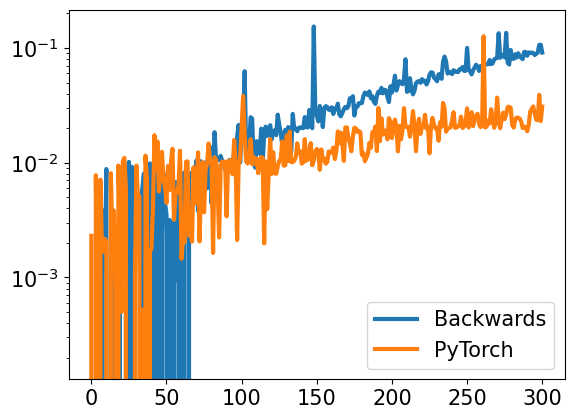

In [23]:
MAX_N = 300

times_backwards = []
times_torch = []
for i in range(0, MAX_N+1):
    times_backwards.append(time_func(get_all_grads_backwards, i))
    times_torch.append(time_func(get_all_grads_torch, i))

plt.plot(range(0, MAX_N+1), times_backwards, linewidth=3)
plt.plot(range(0, MAX_N+1), times_torch, linewidth=3)
plt.legend(['Backwards', 'PyTorch'], fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.yscale('log')
plt.show()